# Google Earth Engine (GEE) DisALEXI 
## Mexico 2015 - Landsat Collection 1 TOA

Example of calling the GEE DisALEXI function on a mosaiced (merging rows) Landsat 8 Collection 1 top-of-atmosphere reflectance image.  
Study area WRS2 tiles: p039r037, p038r037, p039r038, p038r038

https://console.cloud.google.com/storage/browser/gcp-public-data-landsat/LC08/01/038/038/LC08_L1TP_038038_20150717_20170226_01_T1/

In [1]:
import ee
from IPython.display import Image

# For some reason the initialize has to be before the model imports below
ee.Initialize()

import openet.disalexi.disalexi as disalexi
import openet.disalexi.landsat as landsat
import openet.disalexi.utils as utils

ndvi_palette = ['#EFE7E1', '#003300']
ssebop_et_palette = [
  'DEC29B', 'E6CDA1', 'EDD9A6', 'F5E4A9', 'FFF4AD', 'C3E683', '6BCC5C', 
  '3BB369', '20998F', '1C8691', '16678A', '114982', '0B2C7A']

### Study area

In [2]:
output_extent = [624000, 3535000, 714000, 3625000]
output_crs = 'EPSG:32611'
cell_size = 30
output_transform = [cell_size, 0, output_extent[0], 0, -cell_size, output_extent[3]]
output_transform_str = '[' + ','.join(map(str, output_transform)) + ']'
output_shape_str = '{0}x{1}'.format(
    int(abs(output_extent[2] - output_extent[0]) / cell_size),
    int(abs(output_extent[3] - output_extent[1]) / cell_size))
output_region = ee.Geometry.Rectangle(output_extent, output_crs, False) \
    .bounds(1, 'EPSG:4326').coordinates().getInfo()
print(output_transform_str)
print(output_shape_str)

[30,0,624000,0,-30,3625000]
3000x3000


In [3]:
thumbnail_region = [[-115.09, 32.32], [-115.09, 32.40], [-114.95, 32.40], [-114.95, 32.32]]
thumbnail_geom = ee.Geometry.Polygon(thumbnail_region)

### Prep DisALEXI Input

In [4]:
landsat_a_img = ee.Image('LANDSAT/LC08/C01/T1_RT_TOA/LC08_038037_20150717')
landsat_b_img = ee.Image('LANDSAT/LC08/C01/T1_RT_TOA/LC08_038038_20150717')

# Get the projection information from the first image
image_crs = landsat_a_img.select('B2').projection().crs().getInfo()
image_transform = landsat_a_img.select('B2').projection().getInfo()['transform']
image_geom = landsat_a_img.select('B2').geometry()
print(image_crs)
print(image_transform)

# Mosaic images into a single Landsat image
landsat_img = ee.Image(ee.ImageCollection([landsat_a_img, landsat_b_img]).mosaic()) \
    .reproject(crs=image_crs, crsTransform=image_transform)

# Copy the image properties from the first image
landsat_img = ee.Image(landsat_img.copyProperties(landsat_a_img, [
    'system:time_start', 'system:index', 'SPACECRAFT_ID', 
    'K1_CONSTANT_BAND_10', 'K2_CONSTANT_BAND_10']))

input_img = ee.Image(landsat.Landsat(landsat_img).prep())

EPSG:32611
[30.0, 0.0, 659985.0, 0.0, -30.0, 3789615.0]


### NDVI 

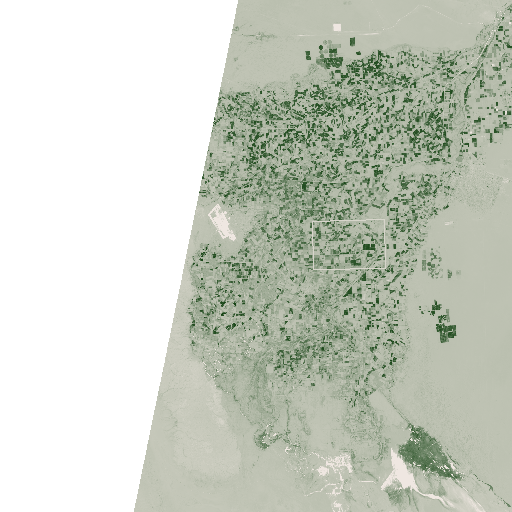

In [ ]:
Image(url=input_img.select(['ndvi']).paint(thumbnail_geom, 'red', 1).getThumbURL({
        'region': output_region, 'min': -0.1, 'max': 0.9, 
        'palette': ','.join(ndvi_palette)}),
      embed=True, format='png')

### Apply DisALEXI

In [ ]:
# Use the CONUS ALEXI ET but the global landcover and elevation products
disalexi = disalexi.Image(
    input_img, 
    iterations=10,
    elevation=ee.Image('USGS/SRTMGL1_003').rename(['elevation']),
    landcover=ee.Image(
        ee.ImageCollection('users/cgmorton/GlobeLand30').mosaic()) \
            .divide(10).floor().multiply(10).rename(['landcover']),
    lc_type='GLOBELAND30')

tair_img = disalexi.compute_ta() \
    .reproject(crs=output_crs, crsTransform=output_transform)

tair_coarse_img = disalexi.aggregate(tair_img)
# tair_smooth_img = disalexi.smooth(tair_coarse_img)

et_img = disalexi.compute_et(tair_coarse_img) \
    .reproject(crs=output_crs, crsTransform=output_transform)

In [ ]:
# print(t_air_img.getInfo())
# print(t_air_coarse_img.getInfo())
# print(et_img.getInfo())

### Export to Drive

In [ ]:
et_task = ee.batch.Export.image.toDrive(
    et_img,
    description='LC08_038XXX_20150717_et',
    folder='DisALEXI',
    fileNamePrefix='LC08_038XXX_20150717_et',
    dimensions=output_shape_str,
    crs=output_crs,
    crsTransform=output_transform_str,
    maxPixels=1E10)

In [ ]:
# tair_task = ee.batch.Export.image.toDrive(
#     tair_img,
#     description='LC08_038XXX_20150717_tair',
#     folder='DisALEXI',
#     fileNamePrefix='LC08_038XXX_20150717_tair',
#     dimensions=output_shape_str,
#     crs=output_crs,
#     crsTransform=output_transform_str,
#     maxPixels=1E10)

In [ ]:
# tair_coarse_task = ee.batch.Export.image.toDrive(
#     tair_coarse_img,
#     description='LC08_038XXX_20150717_tair_coarse',
#     folder='DisALEXI',
#     fileNamePrefix='LC08_038XXX_20150717_tair_coarse',
#     dimensions=output_shape_str,
#     crs=output_crs,
#     crsTransform=output_transform_str,
#     maxPixels=1E10)

In [ ]:
# tair_task.start()
# tair_coarse_task.start()
# et_task.start()
# print('Status: {}'.format(tair_task.status()))
# print('Status: {}'.format(tair_coarse_task.status()))
# print('Status: {}'.format(et_task.status()))

### Thumbnails

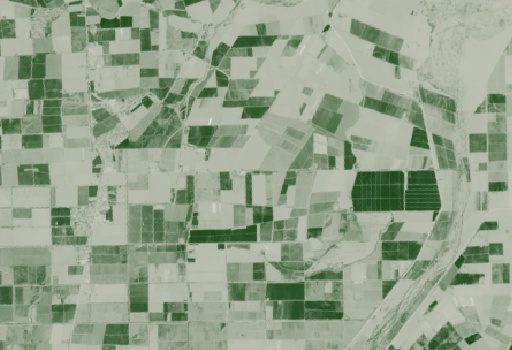

In [ ]:
Image(url=input_img.select(['ndvi']).getThumbURL({
        'region': thumbnail_region, 'min': -0.1, 'max': 0.9, 
        'palette': ','.join(ndvi_palette)}),
      embed=True, format='png')

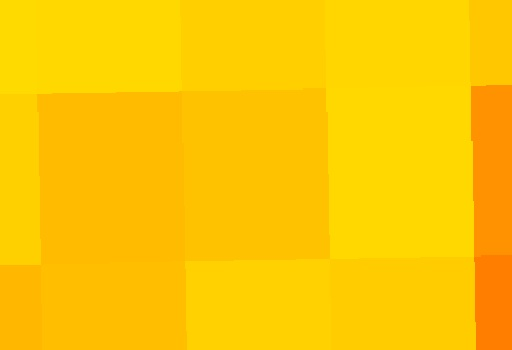

In [ ]:
alexi_url = ee.Image(disalexi.alexi_et).reproject(crs=output_crs, crsTransform=output_transform).getThumbURL({
    'region': thumbnail_region, 'min': 0, 'max': 10, 
    'palette': ','.join(['FF0000', 'FFFF00', '00FFFF', '0000FF'])})
# print(alexi_url)
Image(url=alexi_url, embed=True, format='png')

In [ ]:
tair_url = tair_img.getThumbURL({
    'region': thumbnail_region, 'min': 270, 'max': 330, 
    'palette': ','.join(['FF0000', 'FFFF00', '00FFFF', '0000FF'])})
print(tair_url)
Image(url=tair_url, embed=True, format='png')

https://earthengine.googleapis.com/api/thumb?thumbid=042983bff5c940d83e5a3f2fb53c093c&token=daf39bbb370e1459fd7d67a6020b5820


In [ ]:
# tair_coarse_url = tair_coarse_img.getThumbURL({
#     'region': thumbnail_region, 'min': 270, 'max': 330, 
#     'palette': ','.join(['FF0000', 'FFFF00', '00FFFF', '0000FF'])})
# # print(tair_coarse_url)
# Image(url=tair_coarse_url, embed=True, format='png')

In [ ]:
# et_url = et_img.getThumbURL({
#     'region': thumbnail_region, 'min': 0, 'max': 10, 
#     'palette': ','.join(ssebop_et_palette)})
# # print(et_url)
# Image(url=et_url, embed=True, format='png')

In [ ]:
# def aggregate_daily(image_coll, start_date, end_date, agg_type='mean'):
#     """Aggregate images by day

#     This function should be used to mosaic Landsat images from same path
#         but different rows
#     Aggregation is currently hardcoded to 'mean'
#     system:time_start of returned images will be 0 UTC (not the image time)

#     Image Properties:
#         DATE: Image date string in ISO format (YYYY-MM-DD)

#     Args:
#         image_coll (ee.ImageCollection): Input image collection.
#         start_date (date/number/string): Start date.
#             Needs to be an EE readable date (ISO Date string or milliseconds)
#         end_date (date/number/string): End date.
#             Needs to be an EE readable date (ISO Date string or milliseconds)
#         agg_type (str): Aggregation type.
#             Currently only 'mean' is supported for daily aggregations

#     Returns:
#         ee.ImageCollesction()
#     """
#     date_list = ee.List.sequence(
#         ee.Date(start_date).millis(),
#         ee.Date(end_date).millis(),
#         # ee.Date(end_date).advance(1, 'day').millis(),
#         24 * 3600 * 1000)

#     def set_date(time):
#         """Set system and date properties from a time_start value

#         Intentionally set DOY as 0 padded 3 character string for joining
#         Intentionally set month as integer (not string)
#         """
#         return ee.Feature(None, {
#             'system:index': ee.Date(time).format('yyyyMMdd'),
#             'system:time_start': ee.Number(time).int64(),
#             'DATE': ee.Date(time).format('yyyy-MM-dd'),
#             'MONTH': ee.Number(ee.Date(time).get('month')),
#             'DOY': ee.Number(ee.Date(time).getRelative('day', 'year')) \
#                 .int().add(1).format('%03d'),
#             'TIME_0UTC': ee.Number(time).int64()
#         })
#     date_coll = ee.FeatureCollection(date_list.map(set_date))

#     join_coll = ee.FeatureCollection(
#         ee.Join.saveAll('join').apply(
#             date_coll, image_coll,
#             ee.Filter.equals(leftField='DATE', rightField='DATE')))

#     def aggregate_func(ftr):
#         # The composite image time will not be 0 UTC (not Landsat time)
#         # if agg_type.lower() == 'mean':
#         return ee.ImageCollection.fromImages(ftr.get('join')).mean() \
#             .copyProperties(ftr, etf_properties)

#     return ee.ImageCollection(join_coll.map(aggregate_func))

### DisALEXI ET Collection

In [ ]:
# landsat_coll = ee.ImageCollection('LANDSAT/LC08/C01/T1_RT_TOA') \
#     .filterDate('2015-07-01', '2015-07-02') \
#     .filterBounds(ee.Geometry.Polygon(test_region))
#     # .filterMetadata('WRS_PATH', 'equals', '39')
# print(landsat_coll.aggregate_histogram('system:index').getInfo())

# def apply_disalexi(landsat_img):
#     disalexi = eedisalexi.DisALEXI(
#         ee.Image(landsat.Landsat(landsat_img).prep()), 
#         iterations=10,
#         elevation=ee.Image('USGS/SRTMGL1_003').rename(['elevation']),
#         landcover=ee.Image(
#             ee.ImageCollection('users/nbearson/GlobeLand30_2010').mosaic()) \
#                 .divide(10).floor().multiply(10) \
#                 .rename(['landcover']),
#         lc_type='GLOBELAND30')
#     t_air_img = disalexi.compute_ta()
#     t_air_coarse_img = disalexi.aggregate(t_air_img) \
#         .reproject(crs='EPSG:4326', crsTransform=et_transform)
#     et_img = disalexi.compute_et(t_air_coarse_img) \
#         .reproject(crs=image_crs, crsTransform=image_transform)
#     return et_img

# et_coll = ee.ImageCollection(landsat_coll.map(apply_disalexi))
# print(et_coll.getInfo())

# # pp.pprint(landsat_img.getInfo()['properties'])

In [ ]:
# et_url = ee.Image(et_coll.mosaic()).getThumbURL({
#     'region': test_region, 'min': 1, 'max': 7, 
#     'palette': ','.join(ssebop_et_palette)})
# # print(et_url)

In [ ]:
# Image(url=et_url, embed=True, format='png')